<a href="https://colab.research.google.com/github/clami66/AF_unmasked/blob/notebook/notebooks/AF_unmasked.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color='#2684ff'>AF_unmasked: a simplified notebook</font>

<img src="https://github.com/clami66/AF_unmasked/raw/main/fig/header.png" height="200">

This notebook allows to run AF_unmasked on multimeric sequences and templates of your choice. Not all features implemented on the command line version of AF_unmasked are currently available on the notebook, but more will come later.

This version of AF_unmasked relies on MMseqs2 alignments, run by the [ColabFold](https://github.com/sokrypton/ColabFold) MSA server. Some of the code on this notebook is also based or taken from the ColabFold notebook.

<font color='#2684ff'>**References**</font>

If you use this version of AF_unmasked in your research, consider citing:

- Mirabello et al.: "Unmasking AlphaFold to integrate experiments and predictions in multimeric complexes". [Nature Communications volume 15, 8724 (2024)](https://www.nature.com/articles/s41467-024-52951-w)
- Jumper et al.: "Highly accurate protein structure prediction with AlphaFold". [Nature volume 596, pages 583–589 (2021)](https://www.nature.com/articles/s41586-021-03819-2)
- Evans et al.: "Protein complex prediction with AlphaFold-Multimer". [BiorXiv](https://www.biorxiv.org/content/early/2021/10/04/2021.10.04.463034)
- Mirdita et al. "ColabFold: making protein folding accessible to all" [Nature Methods volume 19, pages 679–682 (2022)](https://www.nature.com/articles/s41592-022-01488-1)

## <font color='#2684ff'>Instructions</font>

The job is configured and launched from the side menu on the left. 

1. <font color='#2684ff'> **Select a name for your job**</font>. Confirm by clicking on the button that will appear or press enter.
1. <font color='#2684ff'> **Upload files**</font>. Two files are neede to run the job:
    * a FASTA file containing multiple sequences for a multimer to predict
    * a PDB (.pdb or .cif) file containing template information for each chain in the multimer
1. <font color='#2684ff'> **Configure the MSA/templates**</font>:
    * **MSA mode**. MSA is disabled by default. Switch to mmseqs2_uniref when inpainting, use mmseqs2_uniref_env if you want to increase MSA depth.
    * **Number of sequences in MSA**. Increase if the inpainted areas are badly predicted, decrease if the prediction does not resemble the template.
    * **Automatically inpaint clashes**. We recommend leaving this on.
    * **Align template sequences to targets**. Disable to let AlphaFold handle the target-template alignments. This is better with remote homologs, but might not work with homomers.
    * **Target-template mapping**. A dropdown menu will appear for each sequence in the fasta file. Select the appropriate chain from the PDB template so that AF_unmasked can use the correct target-template mapping.
1. <font color='#2684ff'> **Format templates**</font>. Press the blue button to convert the templates. Alignments between target and template sequences will be shown in the output window. Make sure the alignments are correct before running the following step.   
1. <font color='#2684ff'> **Configure AlphaFold settings**</font>:
    * **Select AF model type (v2 or v3)**. v2 tends to work better with multimeric templates, but v3 might be better with large multimers. The server generates only model 5 predictions (model_5_v2 or model_5_v3)
    * **Number of predictions**. We recommend starting with 1 until you're happy with the options you have selected
    * **Number of recycles**. Few recycles will be faster. Increasing the recycles might be useful if you are inpainting parts of the structure.
    * **Recycle early stop tolerance**. Leave as default unless you want to run all recycles. In that case lower to 0.0
    * **Use dropout**. Disable if you generate few samples, enable if you generate a lot of samples and want some more diversity in the predictions

1. <font color='#2684ff'> **Run the AF_unmasked job**</font> by clicking on the blue button once you're happy with the parameters and target-template mapping

1. <font color='#2684ff'> **Check and download outputs**</font>. Results will appear in this window. To download the predictions, click on "Output files" at the bottom of the side menu. You will have the option to include all pickle (.pkl) files including extra outputs if needed, keep in mind that these tend to be quite large.
    
## <font color='#2684ff'>Outputs</font>

Outputs will appear below:


In [1]:
is_test = True

In [ ]:
import os
import sys
import json
import pickle
import shutil
import importlib_metadata

from pathlib import Path

from string import ascii_uppercase, ascii_lowercase


class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

cwd = Path.cwd()
ascii_upperlower = ascii_uppercase + ascii_lowercase

python_version = f"{sys.version_info.major}.{sys.version_info.minor}"
PYTHON_VERSION = python_version

print(color.BOLD + "Setting up the environment... ", end="")

if not os.path.isfile("COLABFOLD_READY"):
  print("Installing dependencies...")
  os.system("git clone -b notebook https://github.com/clami66/AF_unmasked.git")
  os.system("pip install numpy<1.20 biopython==1.79 'colabfold[alphafold-minus-jax] @ git+https://github.com/sokrypton/ColabFold'")
  
  os.system("mamba install -y -c conda-forge -c bioconda hmmer kalign2=2.04 hhsuite=3.3.0")
  os.system("touch COLABFOLD_READY")

sys.path.insert(0, f"{cwd}/AF_unmasked")
sys.path.insert(0, f"{cwd}")

import mercury as mr

from AF_unmasked.alphafold.data.prepare_templates import *
from AF_unmasked.alphafold.data.mmseqs_2_uniprot import *
from Bio import Align, SeqIO, AlignIO
from Bio.PDB.mmcifio import MMCIFIO
from Bio.PDB import MMCIFParser

from colabfold.batch import get_msa_and_templates, msa_to_str
from colabfold.utils import DEFAULT_API_SERVER, get_commit
from colabfold.download import download_alphafold_params

from AF_unmasked.run_alphafold import predict_structure
from AF_unmasked.alphafold.data import pipeline, pipeline_multimer

from AF_unmasked.alphafold.data.tools import hmmsearch, jackhmmer
from AF_unmasked.alphafold.data import templates

from AF_unmasked.alphafold.model import model, data, config

import py3Dmol
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.stats import pearsonr
from scipy.special import softmax

from colabfold.colabfold import plot_plddt_legend
from colabfold.colabfold import pymol_color_list, alphabet_list

print("Done."  + color.END)

In [ ]:
app = mr.App(title="AF_unmasked",
        description="",
        show_code=False,
        show_prompt=False,
        continuous_update=True,
        static_notebook=False,
        show_sidebar=True,
        full_screen=True,
        allow_download=False,
        allow_share=True,
        stop_on_error=True
)

jobname = mr.Text(value="", label="Job name", rows=1)
if not jobname.value:
    mr.Stop()


In [ ]:
outdir = mr.OutputDir()
out_dir = Path(outdir.path, jobname.value)
out_dir.mkdir(parents=True, exist_ok=True)
targets = out_dir.joinpath(f"{jobname.value}.fasta")

In [ ]:
# add file upload widget
f = mr.File(label="Upload a single .fasta file for a multimeric target", max_file_size="1MB")
fasta = f.filepath
p = mr.File(label="Upload a template PDB (.pdb, .cif)", max_file_size="20MB")
pdb = p.filepath

if not fasta or not pdb:
    mr.Stop()

In [ ]:
if p.filename.endswith(".pdb"):
  template_format = "pdb"
elif p.filename.endswith(".cif"):
  template_format = "cif"
else:
  raise ValueError("Template must be in .pdb or .cif format")

fasta = Path(fasta)
pdb = Path(pdb)

### <font color='#2684ff'>Sequences and alignments</font>

In [ ]:
_ = shutil.copyfile(fasta, targets)

if not is_fasta(targets):
  raise ValueError("""The input does not appear to be in fasta format
  Example of fasta format input:
  > H1142_A
  GLEKDFLPLYFGWFLTK...
  > H1142_B
  EVQLEESGGGLVQAGGS...
  """)

with open(targets, "r") as f:
  print(color.BOLD + color.RED + "Fasta sequences:" + color.END)
  print(f.read())
  #print()

seq2chain = {}
chain_idx = 0
for record in SeqIO.parse(targets, "fasta"):
  if record.seq not in seq2chain:
    seq2chain[record.seq] = [ascii_upperlower[chain_idx]]
  else:
    seq2chain[record.seq].append(ascii_upperlower[chain_idx])
  chain_idx += 1

In [ ]:
template = out_dir.joinpath(p.filename)
_ = shutil.copyfile(pdb, template)

# template data
template_model = load_PDB(template, is_mmcif=(template_format == "cif"))
template_chains = [c.id for c in template_model]
remove_extra_chains(template_model, template_chains)
remove_hetatms(template_model)
template_sequences = [
        get_fastaseq(template_model, chain) for chain in template_chains
    ]

print(color.BOLD + color.RED + "Template sequences:" + color.END)
for seq, chain in zip(template_sequences, template_chains):
  print(f"Chain {chain}: {seq}")

# target data
target_chains, target_sequences, target_models = get_target_data(
            [str(targets)],
            chains=None,
            is_fasta=True,
            is_mmcif=False,
        )
assert len(target_chains) <= len(
      template_chains
), f"Not enough chains in the template structure to cover all target chains. Partial templates are currently not supported on the colab version of AF_unmasked."

In [ ]:
# MSA and template options
msa_mode = mr.Select(label="MSA mode", choices=["no_MSA", "mmseqs2_uniref", "mmseqs2_uniref_env"])

msa_depth = mr.Select(label="Number of sequences in MSA",
                          choices=["auto", "1", "32", "64", "256", "512"])

msa_depth = None if msa_depth.value == "auto" else int(msa_depth.value)

inpaint_clashes = mr.Checkbox(value=True, label="Automatically inpaint clashes in template")
align = mr.Checkbox(value=True, label="Align template sequences to targets")

align_tool = "blast"

In [ ]:
template_preview = [f"Chain {template_chain} (seq: {template_seq[:10]}...)" for template_chain, template_seq in zip(template_chains, template_sequences)]

template_c = []
for i, ch in enumerate(target_chains):
    template_c.append(mr.Select(label=f"Select template chain for fasta sequence {i+1} (seq: {target_sequences[i][:10]}", value=template_preview[i], choices=template_preview, url_key=i))

repeat_template = mr.Select(label="Repeat template", choices=["1 time", "2 times", "3 times", "4 times"], value="1 time")

run_temp = mr.Button(label="Format templates")

In [ ]:
# Data pipeline


done = False

if run_temp.clicked:
    temp_reps = int(repeat_template.value.split()[0])
    template_chains = [temp.value.split()[1] for temp in template_c]
    
    if len(template_chains) != len(set(template_chains)):
      raise ValueError("Must select a different template chain for each fasta sequence")
    
    append = False
    
    mmcif_path = Path(out_dir, "template_data", "mmcif_files")
    mmcif_path.mkdir(parents=True, exist_ok=True)
    
    for i in range(temp_reps):
        print(color.BOLD + f"Filling template slot n. {i+1}..." + color.END)
        next_id = get_next_id(mmcif_path) if append else "0000"
    
        io = MMCIFIO()
        template_mmcif_path = os.path.join(
            out_dir, "template_data", "mmcif_files", f"{next_id}.cif"
        )
    
        if inpaint_clashes.value:
            template_model = detect_and_remove_clashes(template_model)
            template_sequences = [
                get_fastaseq(template_model, chain) for chain in template_chains
            ]
    
        io.set_structure(template_model)
        io.save(template_mmcif_path)
    
        fix_mmcif(
            template_mmcif_path, template_chains, template_sequences, "2100-01-01"
        )
    
        pdb_seqres_path = Path(out_dir, "template_data", "pdb_seqres.txt").resolve()
        write_seqres(
            pdb_seqres_path,
            template_sequences,
            template_chains,
            seq_id=next_id,
            append=append,
        )
    
        # extra flagfile for AF usage
        af_flagfile_path = Path(out_dir, "template_data", "templates.flag")
        if i == 0:  # don't overwrite file if already there
            with open(af_flagfile_path, "w") as flagfile:
                flagfile.write(f"--template_mmcif_dir={mmcif_path.resolve()}\n")
                flagfile.write(f"--pdb_seqres_database_path={pdb_seqres_path}\n")
                if align.value:  # means we are not going to let AF overwrite pdb_hits.sto
                    flagfile.write("--use_precomputed_msas\n")
    
        if True:
    
            assert len(target_chains) == len(
                template_chains
            ), f"The number of chains to align from target ({target_chains}) doesn't match the number of chains in the template ({template_chains}). Make sure that the files contain the same number of chains or select the chains that should be paired with --target_chains, --template_chains"
            for (
                i,
                (
                    template_chain,
                    template_sequence,
                    target_chain,
                    target_sequence,
                    target_model,
                ),
            ) in enumerate(
                zip(
                    template_chains,
                    template_sequences,
                    target_chains,
                    target_sequences,
                    target_models,
                )
            ):
                msa_chain = ascii_upperlower[i]
                this_template_model = pickle.loads(pickle.dumps(template_model, -1))
                this_target_model = pickle.loads(pickle.dumps(target_model, -1))
                print(color.BOLD + color.RED + f"Aligning fasta sequence {i+1} (seq: {target_sequence[0:10]}...) to template chain {template_chain} (seq: {template_sequence[0:10]}...)" + color.END)
                alignment = do_align(
                    template_sequence,
                    this_template_model,
                    target_sequence,
                    this_target_model,
                    alignment_type="blast",
                )
                sto_alignment = format_alignment_stockholm(
                    alignment, hit_id=next_id, hit_chain=template_chain
                )
    
    
                msa_path = f"msas/{msa_chain}"
    
                # write alignment to file
                Path(out_dir, msa_path).mkdir(parents=True, exist_ok=True)
                with open(
                    Path(out_dir, msa_path, "pdb_hits.sto"),
                    mode="a" if append else "w",
                ) as pdb_hits:
                    for line in sto_alignment:
                        pdb_hits.write(line)
        if temp_reps > 1:
            append = True

    if msa_mode.value == "no_MSA": # same as "no_MSA" on the AF_unmasked paper
      unpaired_msa = []
      for i, ts in enumerate(target_sequences):
        unpaired_msa.append(f"> seq_{i}\n{ts}")
      query_seqs_unique = set(target_sequences)
    else: # Alignments rely on ColabFold's MSA server
      print("Querying ColabFold's MSA server")
      msa_lines = None
      use_templates = False
      custom_template_path = None
      pair_mode = "unpaired"
      pairing_strategy = "greedy"
      host_url = DEFAULT_API_SERVER
      version = importlib_metadata.version("colabfold")
      commit = get_commit()
      if commit:
          version += f" ({commit})"
      user_agent = f"colabfold/{version}"

      unpaired_msa, paired_msa, query_seqs_unique, query_seqs_cardinality, template_features = get_msa_and_templates(jobname.value, target_sequences, msa_lines, out_dir, msa_mode, use_templates,
                              custom_template_path, pair_mode, pairing_strategy, host_url, user_agent)

    for sequence, msa in zip(query_seqs_unique, unpaired_msa):
      chains = seq2chain[sequence]
      for chain in chains:
        out_dir.joinpath(f"msas/{chain}/bfd_uniref_hits.a3m").write_text(msa)
        pseudo_uniprot = open(out_dir.joinpath(f"msas/{chain}/uniprot_hits.a3m"), "w")
        pseudo_uniprot.write(f"> {chain}\n")
        pseudo_uniprot.write(str(sequence))
        pseudo_uniprot.close()

        input_handle  = open(out_dir.joinpath(f"msas/{chain}/uniprot_hits.a3m"), "r")
        output_handle = open(out_dir.joinpath(f"msas/{chain}/uniprot_hits.sto"), "w")

        alignments = AlignIO.parse(input_handle, "fasta")
        AlignIO.write(alignments, output_handle, "stockholm")

        output_handle.close()
        input_handle.close()

    template_searcher = hmmsearch.Hmmsearch(
        binary_path=shutil.which("hmmsearch"),
        hmmbuild_binary_path=shutil.which("hmmbuild"),
        database_path=out_dir.joinpath(f"template_data/pdb_seqres.txt"))

    template_featurizer = templates.HmmsearchHitFeaturizer(
        mmcif_dir=mmcif_path.resolve(),
        max_template_date="2100-01-01",
        max_hits=4,
        kalign_binary_path=shutil.which("kalign"),
        release_dates_path=None,
        obsolete_pdbs_path=None)

    monomer_data_pipeline = pipeline.DataPipeline(
        jackhmmer_binary_path=shutil.which("jackhmmer"),
        hhblits_binary_path=shutil.which("hhblits"),
        uniref90_database_path=".",
        mgnify_database_path="",
        bfd_database_path="",
        uniref30_database_path="",
        small_bfd_database_path="",
        template_searcher=template_searcher,
        template_featurizer=template_featurizer,
        use_small_bfd=False,
        use_precomputed_msas=True,
        mgnify_max_hits=1,
        uniref_max_hits=1,
        bfd_max_hits=msa_depth,
        no_uniref=True,
        no_mgnify=True)

    data_pipeline = pipeline_multimer.DataPipeline(
        monomer_data_pipeline=monomer_data_pipeline,
        jackhmmer_binary_path=shutil.which("jackhmmer"),
        uniprot_database_path=None,
        use_precomputed_msas=True,
        max_uniprot_hits=1,
        separate_homomer_msas=True)


    done = True

if not done:
    mr.Stop()


In [ ]:
# NN options
model_type = mr.Select(label="Select AF model type (v2 or v3)",
                          choices=["alphafold2_multimer_v2", "alphafold2_multimer_v3"])

predictions_per_model = mr.Select(choices=["1", "2", "3", "5", "10", "20"], value="1", label="Number of predictions")
n_preds = predictions_per_model.value

num_recycles = mr.Select(choices=["0", "1", "2", "3", "12", "20"], value="3", label="Number of recycles")
n_recy = num_recycles.value
recycle_early_stop_tolerance = 0.5 #mr.Numeric(value=0.5, min=0.0, max=1.0, label="Recycle early stop tolerance", step=1)

use_dropout = mr.Checkbox(value=True, label="Use dropout (increases sampling noise)")
drop = use_dropout.value

run_pred = mr.Button(label="Run AF_unmasked")

In [ ]:
# Prediction step


done2 = False
if run_pred.clicked:
    data_dir = Path("./")
    if not glob.glob(f"{data_dir}/params/*_finished.txt"):
      print("downloading AF parameters...")
      download_alphafold_params(model_type.value, data_dir)

    model_names = ["model_5_multimer_v2"] if model_type.value == "alphafold2_multimer_v2" else ["model_5_multimer_v3"]
    model_runners = {}

    for model_name in model_names:
        model_config = config.model_config(model_name)
        model_config.model.num_ensemble_eval = 1
        model_config.model.embeddings_and_evoformer.cross_chain_templates = True
        model_config.model.num_recycle = int(n_recy)
        model_config.model.global_config.eval_dropout = drop
        model_config.model.recycle_early_stop_tolerance = recycle_early_stop_tolerance

        model_params = data.get_model_haiku_params(
            model_name=model_name, data_dir=str(data_dir))
        model_runner = model.RunModel(model_config, model_params)
        for i in range(int(n_preds)):
          model_runners[f'{model_name}_pred_{i}'] = model_runner

    if not is_test:
        predict_structure(
            fasta_path=targets,
            fasta_name=jobname.value,
            output_dir_base=f"{outdir.path}",
            data_pipeline=data_pipeline,
            model_runners=model_runners,
            benchmark=False,
            random_seed=0,
            models_to_relax=None)
    else:
        template =  os.path.join(out_dir, "template_data", "mmcif_files", "0000.cif")
        os.system(f"rsync -av ./mercury_example/ {out_dir}")
    done2 = True

if not done2:
    mr.Stop()

In [ ]:
exclude_pickles = True 
# mr.Checkbox(value=True, label="Exclude pickle files (.pkl) from download")
# run_zip = mr.Button(label="Zip results for download")
#if run_zip.clicked:
extra_zip_flags = "-x '*.pkl'" if exclude_pickles else ""
results_zip = f"{jobname.value}.zip"
_ = os.system(f"cd {outdir.path} && zip {extra_zip_flags} -r {results_zip} {jobname.value}")

### <font color='#2684ff'>Scores and plots </font>


In [ ]:
ranking_debug = out_dir.joinpath("ranking_debug.json")
rank_choices = [Path(ranked_pdb).stem for ranked_pdb in glob.glob(f"{out_dir}/ranked_*.pdb")]
rank_choices = sorted(rank_choices, key=lambda x: int(x.split("_")[-1].split(".")[0]))
if ranking_debug.is_file():
    print(color.BOLD + color.RED + "Ranking confidence scores:" + color.END)
    ranking = json.load(open(ranking_debug))
    for i, key in enumerate(ranking["order"]):
        if "iptm+ptm" in ranking:
            print(f"  ranked_{i}: {ranking['iptm+ptm'][key]}")
        else:
            print(f"  ranked_{i}: {ranking['plddts'][key]}")

In [ ]:
if msa_mode.value != "no_MSA":
    print(color.BOLD + color.RED + "MSA:" + color.END)
    msa = pickle.load(open(f"{out_dir}/features.pkl", "rb"))["msa"]
    plt.imshow(msa)
    plt.show()

In [ ]:
ranked_pdb = mr.Select(label="Select structure by rank", choices=rank_choices, value=rank_choices[0])
col = mr.Select(label="Select structure coloring", choices=["chain", "lDDT", "rainbow"], value="chain")
show_sidechains = mr.Checkbox(value=False, label="Show sidechains")

In [ ]:
def show_pdb(pdb_file, extension, show_sidechains=False, show_mainchains=False, color="lDDT"):
  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',)
  view.addModel(open(pdb_file,'r').read(), extension)

  if color == "lDDT":
    view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':50,'max':90}}})
  elif color == "rainbow":
    view.setStyle({'cartoon': {'color':'spectrum'}})
  elif color == "chain":
    chains = len(target_sequences) + 1
    for n,chain,color in zip(range(chains),alphabet_list,pymol_color_list):
       view.setStyle({'chain':chain},{'cartoon': {'color':color}})

  if show_sidechains:
    BB = ['C','O','N']
    view.addStyle({'and':[{'resn':["GLY","PRO"],'invert':True},{'atom':BB,'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"GLY"},{'atom':'CA'}]},
                        {'sphere':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"PRO"},{'atom':['C','O'],'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
  if show_mainchains:
    BB = ['C','O','N','CA']
    view.addStyle({'atom':BB},{'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})

  view.zoomTo()
  return view

def get_distance_predictions(results, interpolate=True):
    bin_edges = results["distogram"]["bin_edges"]
    bin_edges = np.insert(bin_edges, 0, 0)

    if interpolate:
        distogram_softmax = softmax(results["distogram"]["logits"], axis=2)
        distance_predictions = np.sum(np.multiply(distogram_softmax, bin_edges), axis=2)
    else:  # pick maximum probability distance instead
        distogram_argmax = np.argmax(
            results["distogram"]["logits"][:, :, :63], axis=2
        )  # skips last bin to avoid being too conservative
        distance_predictions = bin_edges[distogram_argmax]

    return distance_predictions

def load_results(filepath, interpolate=True):

    with open(filepath, "rb") as p:
        results = pickle.load(p)
        distance_predictions = get_distance_predictions(results, interpolate)
        if "predicted_aligned_error" in results:
            pae = results["predicted_aligned_error"]
        else:
            pae = None
    return distance_predictions, pae

def plot_distances(filepath, distances, pae=None, limitA=None, limitB=None):

    if pae is not None:
        fig, ax = plt.subplots(1, 2)
        d = ax[0].imshow(distances)
        plt.colorbar(d, ax=ax[0], fraction=0.046, pad=0.04)
        p = ax[1].imshow(pae)
        plt.colorbar(p, ax=ax[1], fraction=0.046, pad=0.04)
        ax[0].title.set_text("Distance map")
        ax[1].title.set_text("Predicted aligned error")
        ax[1].set_yticks([])
    else:
        fig, ax = plt.subplots()
        d = ax.imshow(distances)
        plt.colorbar(d, ax=ax, fraction=0.046, pad=0.04)
        ax.title.set_text("Distance map")

    if limitA and limitB:
        # plots a bounding box if any
        rect1, rect2 = get_bounding_boxes(limitA, limitB)

        if pae is not None:
            rect3 = copy(rect1)
            rect4 = copy(rect2)
            ax[0].add_patch(rect1)
            ax[0].add_patch(rect2)
            ax[1].add_patch(rect3)
            ax[1].add_patch(rect4)
        else:
            ax.add_patch(rect1)
            ax.add_patch(rect2)
    
    plt.savefig(filepath, dpi=200, bbox_inches='tight')
    plt.show()
    plt.close()
    
def compare_to_native(
    filepath,
    pdb_path,
    predicted_distances,
    limitA=None,
    limitB=None,
):

    parser = MMCIFParser(QUIET=True)
    structure = parser.get_structure("model", pdb_path)

    compared_dist = np.triu(predicted_distances)

    c_alphas = [r["CB"] if "CB" in r else r["CA"] for r in structure.get_residues()]

    for i, ca_i in enumerate(c_alphas):
        for j, ca_j in enumerate(c_alphas):
            if j < i:
                dist = ca_i - ca_j
                compared_dist[i, j] = min(dist, 22)

    if limitA and limitB:
        predicted_distances = predicted_distances[
            limitA[0] - 1 : limitA[1], limitB[0] - 1 : limitB[1]
        ]
        real_dist = np.zeros_like(predicted_distances)
        real_dist = np.transpose(
            compared_dist[limitB[0] - 1 : limitB[1], limitA[0] - 1 : limitA[1]]
        )
    else:
        predicted_distances = np.triu(predicted_distances)
        real_dist = np.transpose(np.tril(compared_dist))

    fig, ax = plt.subplots(1, 2, gridspec_kw={"width_ratios": [1, 0.9]})
    plt.subplots_adjust(
        left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4
    )

    d = ax[0].imshow(compared_dist)
    plt.colorbar(d, ax=ax[0], fraction=0.046, pad=0.04)
    ax[0].set_ylabel("← Template distances")
    ax[0].set_xlabel("Predicted distances →")
    ax[0].xaxis.set_label_position("top")
    ax[0].set_yticks([])
    ax[1].set_xlim(0, 22)
    ax[1].set_ylim(0, 22)
    ax[1].set_box_aspect(1)
    ax[1].scatter(real_dist.reshape(-1), predicted_distances.reshape(-1))
    corr = pearsonr(real_dist.reshape(-1), predicted_distances.reshape(-1))[0]
    #print(f"    Pearson correlation: {corr:.3f}")
    lims = [
        np.min([ax[1].get_xlim(), ax[1].get_ylim()]),  # min of both axes
        np.max([ax[1].get_xlim(), ax[1].get_ylim()]),  # max of both axes
    ]
    ax[1].plot(lims, lims, "k-", alpha=0.75, zorder=0)
    ax[1].set_xlabel("PDB model distances")
    ax[1].set_ylabel("Distogram distances")

    if limitA and limitB:
        # plots a bounding box if any
        rect1, rect2 = get_bounding_boxes(limitA, limitB)
        ax[0].add_patch(rect1)
        ax[0].add_patch(rect2)

    ax[0].set_title("Template-Prediction\ncomparison")
    ax[1].set_title(f"Distance agreement\nPearson r: {corr:.3f}")

    plt.savefig(filepath, dpi=200, bbox_inches='tight')
    plt.show()
    plt.close()

rank_n = int(ranked_pdb.value.split("_")[-1].split(".")[0])
result_pickle = out_dir.joinpath(f"result_{ranking['order'][rank_n]}.pkl")
result_png = out_dir.joinpath(f"result_{ranking['order'][rank_n]}.pkl.png")
result_agreement_png = out_dir.joinpath(f"result_{ranking['order'][rank_n]}.agreement.pkl.png")

if not result_png.is_file() or not result_agreement_png.is_file():
    dist, pae = load_results(result_pickle)
    plot_distances(result_png, dist, pae)
    compare_to_native(result_agreement_png, template_mmcif_path, dist)
else:
    plt.axis('off')
    distplot = mpimg.imread(result_png)
    compplot = mpimg.imread(result_agreement_png)
    plt.imshow(distplot)
    plt.show()
    plt.axis('off')
    plt.imshow(compplot)
    plt.show()

### <font color='#2684ff'>Structures</font>

In [ ]:
prediction_pdb = f"{out_dir}/{ranked_pdb.value}.pdb"

print(color.BOLD + f"Prediction {ranked_pdb.value}.pdb" + color.END)
pred = show_pdb(prediction_pdb, "pdb", show_sidechains.value, False, col.value)
pred.show()

In [ ]:
print(color.BOLD + "Template" + color.END)
template_pdb = f"{mmcif_path}/0000.cif"
temp = show_pdb(template_pdb, "cif", show_sidechains.value, False, col.value)
temp.show()

## <font color='#2684ff'>Download results </font>

Click on the button at the bottom of the menu:

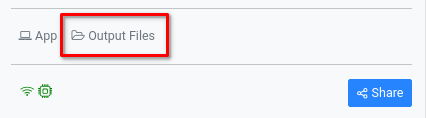